In [1]:
# from google.colab import drive
# drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# !unzip /content/drive/MyDrive/Inno/Radiomics/jpg/image_mutation.zip -d /content/

In [ ]:
# !unzip /content/drive/MyDrive/Inno/Radiomics/jpg/image_no_mutation.zip -d /content/

In [ ]:
# !unzip /content/drive/MyDrive/Inno/Radiomics/jpg/image_unknown_over_500.zip -d /content/

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder, MNIST
from torchvision import transforms
from torch import autograd
from torchvision.utils import make_grid
import torchvision
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torch.autograd import Variable


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
device

device(type='cuda')

In [2]:
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class CustomImageDataset(Dataset):
    def __init__(self, mutation_dir, no_mutation_dir, transform=None):
        self.mutation_dir = mutation_dir
        self.no_mutation_dir = no_mutation_dir
        self.transform = transform

        self.mutation_images = os.listdir(mutation_dir)
        self.no_mutation_images = os.listdir(no_mutation_dir)

        self.total_images = self.mutation_images + self.no_mutation_images

    def __len__(self):
        return len(self.total_images)

    def __getitem__(self, idx):
        if idx < len(self.mutation_images):
            label = 1
            img_name = os.path.join(self.mutation_dir, self.mutation_images[idx])
        else:
            label = 0
            img_name = os.path.join(self.no_mutation_dir, self.no_mutation_images[idx - len(self.mutation_images)])

        image = Image.open(img_name).convert('L')
        if self.transform:
            image = self.transform(image)

        return image, label

# Использование DataLoader
transform = transforms.Compose([
    #transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = CustomImageDataset('image_mutation', 'image_no_mutation', transform=transform)
train_data, test_data = train_test_split(dataset, test_size=0.2)

# Создание DataLoader для обучающей и тестовой выборок
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

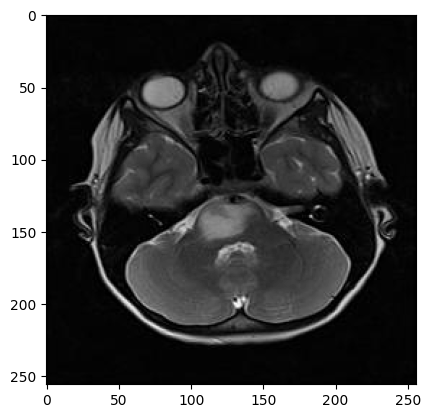

In [3]:
import matplotlib.pyplot as plt

# Получение одного батча изображений из DataLoader
images, labels = next(iter(train_loader))

# Отображение первого изображения из батча
plt.imshow(images[0].numpy().squeeze(), cmap='gray')
plt.show()


In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.label_emb = nn.Embedding(2, 2)

        self.model = nn.Sequential(
            nn.Linear(65538, 2048),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(2048, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        x = x.view(x.size(0), 65536)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.label_emb = nn.Embedding(2, 2)

        self.model = nn.Sequential(
            nn.Linear(258, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 2048),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(2048, 65536),
            nn.Tanh()
        )

    def forward(self, z, labels):
        z = z.view(z.size(0), 256)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 256, 256)

In [6]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

In [7]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.SGD(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [8]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 256)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 2, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
    g_loss.backward()
    g_optimizer.step()
    return g_loss.item()

In [9]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).cuda())

    # train with fake images
    z = Variable(torch.randn(batch_size, 256)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 2, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).cuda())

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()

In [ ]:
num_epochs = 100
n_critic = 5
display_step = 300
for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch))
    for i, (images, labels) in enumerate(train_loader):
        real_images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        generator.train()
        batch_size = real_images.size(0)
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)


        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)

    generator.eval()
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
    z = Variable(torch.randn(2, 256)).cuda()
    labels = Variable(torch.LongTensor(np.arange(2))).cuda()
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()